# Module 4 Final Project Submission
## Time Series Analysis

Student name: Fernando Aguilar Islas<br>
Student pace: Part-Time<br>
Scheduled project review date/time:<br>
Instructor name: Brandon Lewis<br>
Blog post URL:<br>

## 1. Introduction
For this project I will be performing time series analysis on housing historical data obtained from Zillow. Real Estate, Inc. is looking for the 5 best zipcodes in the US to begin developing its newest multi-family residential complex. Real Estate, Inc. is looking for busy and dense metropolitan areas with an average house prices around the median.

## 2. Methodology

First, I will select the relevant zipcodes by using EDA. I'm only interested in zipcodes with a size rank in the top 20% size rank. Then, I will select zipcodes with an average house price between 1 decile above and 1.5 deciles below teh median. I will calculate the periodic returns and perform time series analysis to forecast next year's return.

In regards to the tme series analysis I will be using the Box–Jenkins method:

1. Identification. Use the data and all related information to help select a sub-class of model that may best summarize the data.
2. Estimation. Use the data to train the parameters of the model (i.e. the coefficients).
3. Diagnostic Checking. Evaluate the fitted model in the context of the available data and check for areas where the model may be improved. source: https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/

In [214]:
#Import the necessary libraries for EDA, visualization and time series modelling.
#Data visualization and manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')
%matplotlib inline
#Time series analysis tools.
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [311]:
#Helper Functions
#Obtain dates form the data. Source: Flatiron School
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

#Convert the data into long format. Source: Flatiron School
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def acf_pacf(df,alags=48,plags=48):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    #Make ACF plot
    plot_acf(df,lags=alags, zero=False,ax=ax1)
    #Make PACF plot
    plot_pacf(df,lags=plags, ax=ax2)
    plt.show()

def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_70808 - TS_70808.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();
    
def train_test(df):
    #Set trainning dsata before 2016
    train = df[:'2015-04']
    #Set test data starting 2016
    test = df['2015-05':]
    return train, test

def model_fit(df,pdq=(1,0,1),pdqs=(1,0,1,12)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

def pred_RMSE(train, test, results, display = True):
    test_pred= results.predict('2015-04','2018-04')[1:]
    train_pred = results.predict(-36)
    print(f'SARIMA model RMSE on train data:{sqrt(MSE(train[-36:],train_pred))}')
    print(f'SARIMA model RMSE on test data:{sqrt(MSE(test,test_pred))}')
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual vs. Predicted Returns')
        plt.show()
        

## 3. Exploratory Data Analysis (Zipcode Selection)

In [3]:
#Instantiate pandas dataframe with housing data.
df_zillow = pd.read_csv('zillow_data.csv')
print(df_zillow.info(),'\n')
print(f'Unique zipcodes: {df_zillow.RegionName.nunique()}')
df_zillow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None 

Unique zipcodes: 14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


From this initial EDA, I can see that the data is provided in wide-format. Further down the project I will transform the data into a long-format. There are 14,723 unique zipcodes in the data, hence the next step will be to select the zipcodes that fit Real Estate, Inc. target market requirements.

In [4]:
#Get zipcodes with a size rank in the top 20% (highly urbanized zipcodes).
print(df_zillow.SizeRank.describe(),'\n')
#Calculate the 20% cutoff value.
sr_20 = df_zillow.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {sr_20}')
#Get data frame with selected zipcodes. Keep values and zipcodes only.
zc_top20= df_zillow[df_zillow['SizeRank']<sr_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(zc_top20)}')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64 

Size Rank 20% cutoff value: 2945.4
Amount of zipcodes: 2945


The number of zipcodes to consider has been narrowed down from a total of 14,723 to only a fifth of that, 2,945. Now, I will look into zipcodes with an average value of between 1 decile above the median and 1.5 deciles below the median. I will calculate the average value using data form last year to represent the prices the company is likely to encounter currenlty.

In [5]:
zc_top20['yr_avg']=zc_top20.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(zc_top20['yr_avg'].describe(),'\n')
#Calculate the 60% cutoff value (1 decile above).
q_60 = zc_top20['yr_avg'].quantile(q=0.60)
print(f'Average Value 60% cutoff value: {round(q_60,2)}')
#Calculate the 35% cutoff value (1.5 deciles below).
q_35 = zc_top20['yr_avg'].quantile(q=0.35)
print(f'Average Value 35% cutoff value: {round(q_35,2)}')
#Get data frame with selected zipcodes.
zc_pref= zc_top20[(zc_top20['yr_avg']<q_60) & (zc_top20['yr_avg']>q_35)]
print(f'Amount of zipcodes: {len(zc_pref)}')

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64 

Average Value 60% cutoff value: 290211.67
Average Value 35% cutoff value: 198641.67
Amount of zipcodes: 736


The number of zipcodes to consider is now 736. This takes into account the urbanization and home value preferences of the real estate company. It is time to look into the investement perspective, hence, I will look at the historical return on investment,standard deviation and calculate the coefficient of variance to take into account the risk profile of the firm.

In [6]:
#Calculate historical return on investment
zc_pref['ROI']= (zc_pref['2018-04']/zc_pref['1996-04'])-1
#Calculate standard deviation of monthly values
zc_pref['std']=zc_pref.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
#Calculate historical mean value
zc_pref['mean']=zc_pref.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
#Calculate coefficient of variance
zc_pref['CV']=zc_pref['std']/zc_pref['mean']
#Show calculated values
zc_pref[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
11,32162,53805.394161,183692.830189,1.493069,0.292910
14,37013,19771.938500,139191.698113,0.885231,0.142048
17,37211,36496.608464,147387.924528,1.698672,0.247623
18,78660,24894.592870,168193.584906,0.748020,0.148012
22,77573,29647.359699,183261.509434,0.848656,0.161776


In [7]:
#Descriptive statistics of coefficients of variance.
print(zc_pref.CV.describe())
#Define upper limit of CV according to risk profile.
upper_cv = zc_pref.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')
#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = zc_pref[zc_pref['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['RegionName','ROI','CV']]

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64

CV upper limit: 0.25459687610566145

 Best 5 Zipcodes:


,RegionName,ROI,CV
1784,70808,2.258519,0.251359
1877,29461,2.061224,0.249053
2213,3820,1.988142,0.248366
1375,52722,1.948396,0.244641
2931,70809,1.930894,0.239323


In [8]:
#Get Location Names
best5_zipcodes = list(zc_best5.RegionName.values)
for i in best5_zipcodes:
    city = df_zillow[df_zillow['RegionName']==i].City.values[0]
    state = df_zillow[df_zillow['RegionName']==i].State.values[0]
    print(f'Zipcode : {i} \nLocation: {city}, {state}\n')

Zipcode : 70808 
Location: Baton Rouge, LA

Zipcode : 29461 
Location: Moncks Corner, SC

Zipcode : 3820 
Location: Dover, NH

Zipcode : 52722 
Location: Bettendorf, IA

Zipcode : 70809 
Location: Baton Rouge, LA



I have successfully identified the best 5 zipcodes according to Real Estate, Incs. target market income preferences by choosing zip codes with current avearge home values around the median. Also, the zip codes were narrowed down by size rank, with a preference for more urbanized areas. At the end, another criteria was the highest return on investment given the risk profile of the developer. Now, its time to perform time series analysis on this zip codes to develop a model that makes accurate forecasts.

## 4 Time Series Analysis
I will start by transforming the wide-formatted data of the 5 zipcodes into a long-form time series. Then, i will plot them and test for stationarity in order to be able to find the most sutiable model.

In [9]:
TS_zc5 = zc_best5.drop(['yr_avg','std','mean','ROI','CV'],axis=1)
TS_zc5 = melt_data(TS_zc5).set_index('time')
print('Time series data for the 5 zipcodes:\n',TS_zc5.head())
#Create individualized time series for each zipcode.
#List containing the 5 different time series.
dfs_ts = []
for zc in TS_zc5.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = TS_zc5[TS_zc5['RegionName']==zc].asfreq('MS')
    dfs_ts.append(df)
print('\nZipcode 70808 time series:')
dfs_ts[0].head()

Time series data for the 5 zipcodes:
             RegionName     value
time                            
1996-04-01       70808   85100.0
1996-04-01       29461   68600.0
1996-04-01        3820  101200.0
1996-04-01       52722   71700.0
1996-04-01       70809   73800.0

Zipcode 70808 time series:


,RegionName,value
time,,
1996-04-01,70808,85100.0
1996-05-01,70808,85600.0
1996-06-01,70808,86000.0
1996-07-01,70808,86600.0
1996-08-01,70808,87200.0


Now I will lokk at the descriptive statiscits for the values for each of tha zipcodes and plot the times series to visually test for tresnds and seasonality.

In [10]:
for i in range(len(dfs_ts)):
    print(f'Value descriptive statistics for zipcode {dfs_ts[i].RegionName[0]}:')
    print(f'{dfs_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 70808:
count       265.000000
mean     177707.547170
std       44668.407286
min       85100.000000
25%      142500.000000
50%      196900.000000
75%      208000.000000
max      277300.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 29461:
count       265.000000
mean     145173.207547
std       36155.846366
min       68000.000000
25%      115700.000000
50%      157300.000000
75%      168500.000000
max      210000.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 3820:
count       265.000000
mean     213244.905660
std       52962.689684
min      101200.000000
25%      188500.000000
50%      226100.000000
75%      250600.000000
max      302400.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 52722:
count       265.000000
mean     155742.264151
std       38100.881176
min       70000.000000
25%      133400.000000
50%      168300.000000
75%      183500.000000
max      

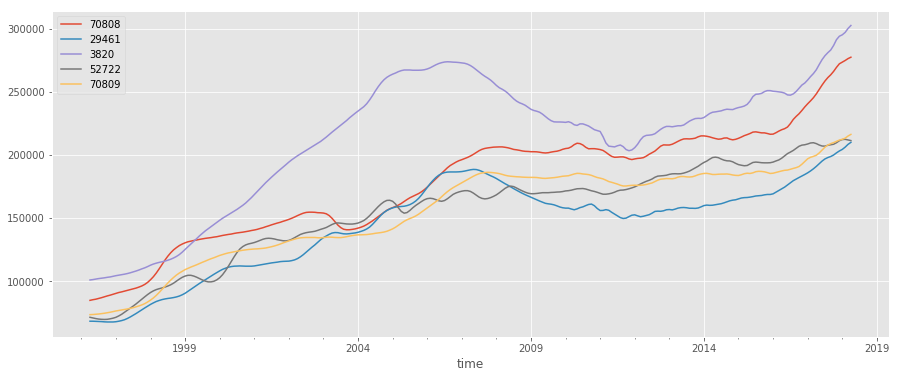

In [11]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0],figsize=(15,6))
    plt.legend()

From the plot, it is somewhat clear that there is an upward trend in values. This is of no surprise since the housing market is expected to appreciate over time. Although prices are similar, a better way to compare these zipcodes is by monthtly returns. This is because returns can be comparable with each other, and prices are dependent on the previous price.

In [12]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1        

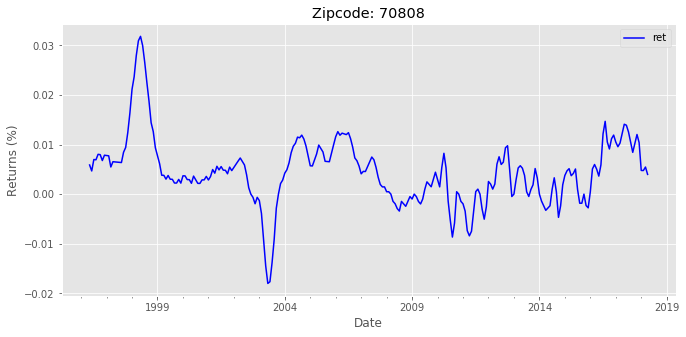

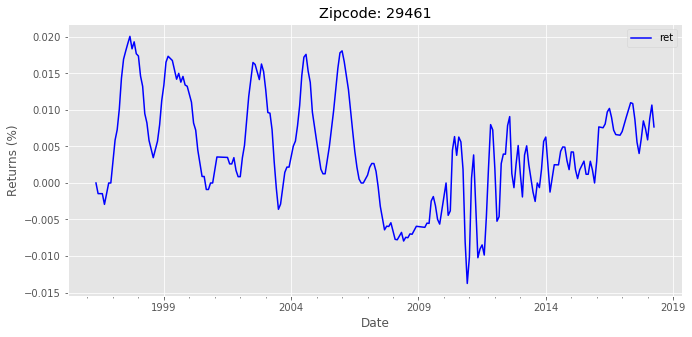

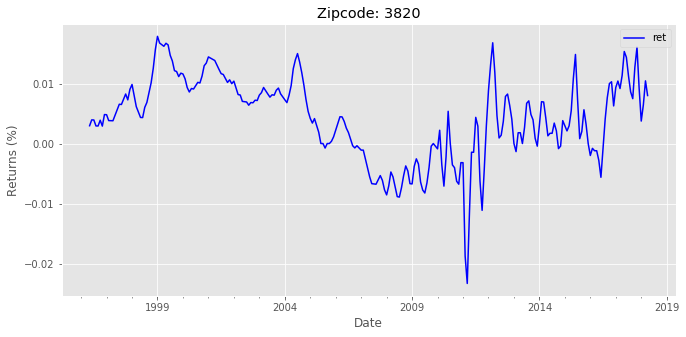

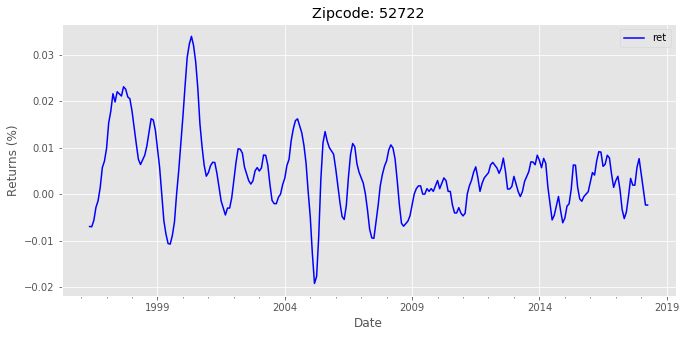

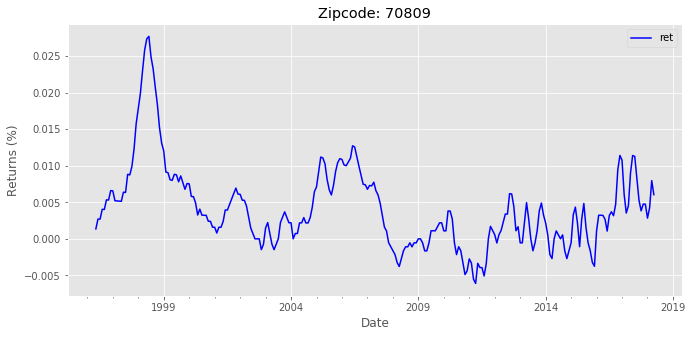

In [13]:
#Plot the monthly returns of each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

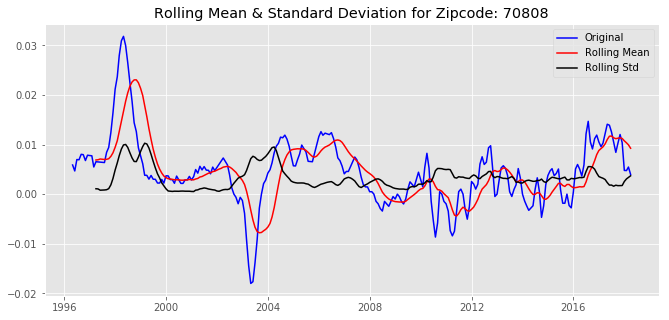

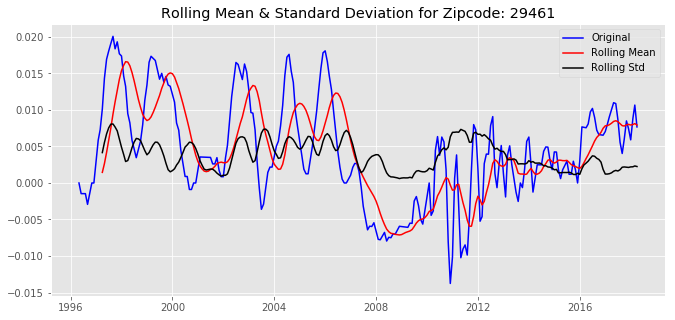

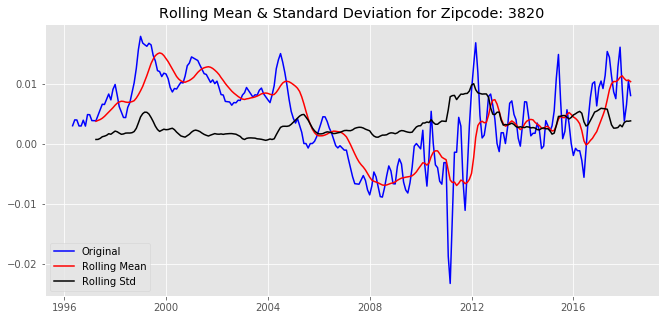

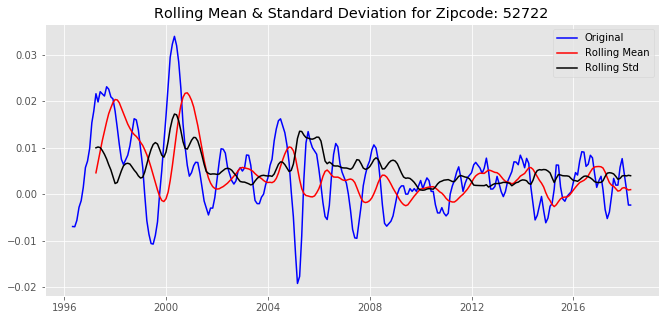

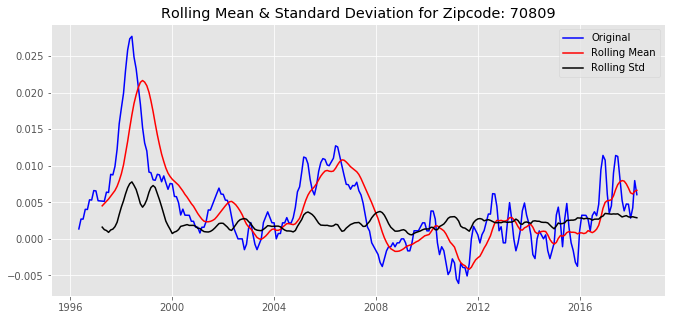

In [14]:
#Plot each of the zipcodes' returns with their respective rolling mean and rolling standard deviation.
#Vizually test for stationarity.
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].ret.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

Visually the data seems quite stationary. I will perform the Augmented Dickey-Fuller test to challenge the visualizations, and find out if data is trully stationary. The null hypothesis of the Augmented Dickey-Fuller is that there is an order of integration (data is not stationary), with the alternative that there is not (data is stationary). I will set a 95% confidence level, hence, I will reject the null-hypothesis if the p-value is lower than 0.05.

In [15]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 70808
p-value: 0.024753431146719584
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 29461
p-value: 0.3548707714514657
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 3820
p-value: 0.36376171386715545
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 52722
p-value: 1.780143393207466e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 70809
p-value: 0.1059872001451227
Fail to reject the null hypothesis. Data is not stationary.



Only 2 of the zipcodes monthly return time series are stationary. I will take the first difference of the other 3 zipcodes to check on the effect on stationarity.

In [16]:
for i in [1,2,4]:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 29461
p-value: 1.60489096321814e-10
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 3820
p-value: 4.81953628416474e-09
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 70809
p-value: 1.2367474751675888e-06
Reject the null hypothesis. Data is stationary.



By taking the first difference, the p-values significantly decreased below the 0.05 threshold. As of now, the I (Integration) of the SARIMA model is best estimated to be 0 for zipcodes 70808 and 52722, and 1 for the others. Now I will plot the ACF and PACF for each of the zipcodes to try to estime the p and q values to be used when fitting the final SARIMA model.

In [48]:
#Instantiate individual time series for each of the zipcodes.
TS_70808 = dfs_ts[0].ret.dropna()#Zipcode 70808 monthly returns time series

TS_29461 = dfs_ts[1].ret.dropna()#Zipcode 29461 monthly returns time series
TS_29461d = dfs_ts[1].ret.diff().dropna()#Zipcode 29461 monthly returns differenced time series

TS_3820 = dfs_ts[2].ret.dropna()#Zipcode 3820 monthly returns time series
TS_3820d = dfs_ts[2].ret.diff().dropna()#Zipcode 3820 monthly returns differenced time series

TS_52722 = dfs_ts[3].ret.dropna()#Zipcode 52722 monthly returns time series

TS_70809 = dfs_ts[4].ret.dropna()#Zipcode 70809 monthly returns time series
TS_70809d = dfs_ts[4].ret.diff().dropna()#Zipcode 70809 monthly returns differenced time series

### 4.1 Zip code 70808
I will start to plot the ACF and PACF to find the p and q parameters of this zipcode's SARIMA model. It has already been estblished that the I parameter is most likely to be 0 since the data is already stationary.

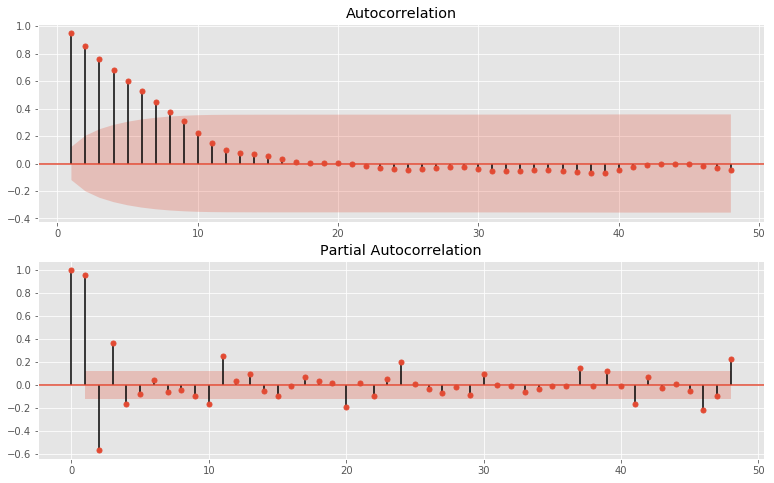

In [78]:
acf_pacf(TS_70808)

From the plots, since the ACF plot is tailing off is very likely that the MA(q) parameter is 0 and the AR(p) parameter around 3 or 4. Hoewever there are still statistically significant values in the PACF after lag 4 wich might entail a full ARMA model with p and q parameters. Now lets look for seasonality in the returns.

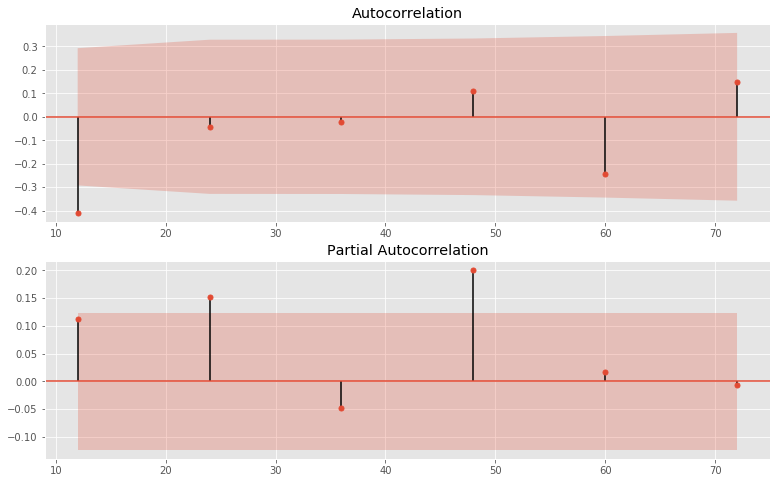

In [89]:
season_acf(TS_70808, N=13)

There may be a 12 month seasonality given that there is a statistically significant peak in the ACF plot around lag 12. However, this is not repeated in other lags, so it is probable that there is no seasonality in the results. With the realized information and parameter estatimates, lets begin modelling the monthy returns using a SARIMA model.

In [121]:
#USe auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_70808,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=2, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-2604.909, BIC=-2583.453, Fit time=0.705 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1884.406, BIC=-1877.254, Fit time=0.043 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-2419.957, BIC=-2405.654, Fit time=0.456 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2608.842, BIC=-2590.963, Fit time=0.567 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=-2595.499, BIC=-2581.195, Fit time=0.231 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=-2602.323, BIC=-2580.867, Fit time=2.051 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=-2607.121, BIC=-2582.090, Fit time=2.151 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-2606.199, BIC=-2584.744, Fit time=0.617 seconds
Fit ARIMA: order=(1, 0, 

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

I got the following parameters for the SARIMA model:<br>
p = 1, q = 1<br>
P = 0, Q = 1<br>
Lets proceed to fit the model according to this parameters.

                                 Statespace Model Results                                 
Dep. Variable:                                ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                1132.586
Date:                            Tue, 02 Jul 2019   AIC                          -2257.171
Time:                                    16:10:37   BIC                          -2243.454
Sample:                                05-01-1996   HQIC                         -2251.637
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9328      0.018     52.833      0.000       0.898       0.967
ma.L1          0.6121      0.051   

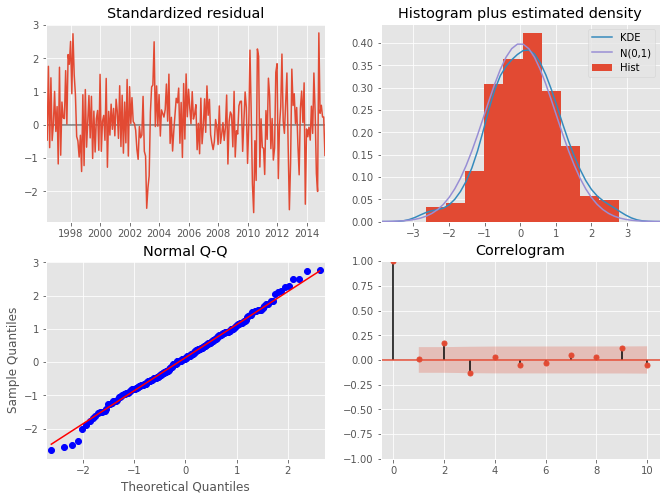

In [294]:
#Fit the SARIMA model and get results.
train, test, results = model_fit(TS_70808,pdq=(1,0,1),pdqs=(0,0,1,12))

SARIMA model RMSE on train data:0.001956403675534825
SARIMA model RMSE on test data:0.008441127667917185


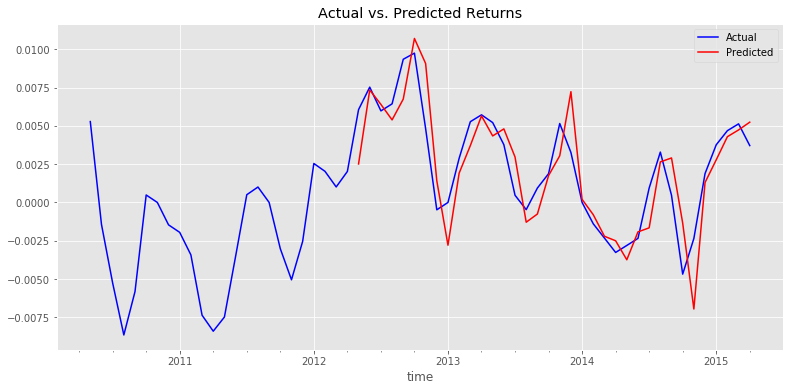

In [312]:
pred_RMSE(train, test, results)

In [313]:
train_pred = results.predict(-36)
train_pred.index
print(f'SARIMA model RMSE on train data:{sqrt(MSE(train[-36:],train_pred))}')

SARIMA model RMSE on train data:0.001956403675534825


In [280]:
train[-36:]

time
2012-05-01    0.006064
2012-06-01    0.007534
2012-07-01    0.005982
2012-08-01    0.006442
2012-09-01    0.009355
2012-10-01    0.009756
2012-11-01    0.004831
2012-12-01   -0.000481
2013-01-01    0.000000
2013-02-01    0.002886
2013-03-01    0.005276
2013-04-01    0.005725
2013-05-01    0.005218
2013-06-01    0.003775
2013-07-01    0.000470
2013-08-01   -0.000470
2013-09-01    0.000940
2013-10-01    0.001879
2013-11-01    0.005157
2013-12-01    0.003265
2014-01-01    0.000000
2014-02-01   -0.001395
2014-03-01   -0.002328
2014-04-01   -0.003266
2014-05-01   -0.002809
2014-06-01   -0.002347
2014-07-01    0.000941
2014-08-01    0.003291
2014-09-01    0.000469
2014-10-01   -0.004684
2014-11-01   -0.002353
2014-12-01    0.001887
2015-01-01    0.003766
2015-02-01    0.004690
2015-03-01    0.005135
2015-04-01    0.003716
Freq: MS, Name: ret, dtype: float64

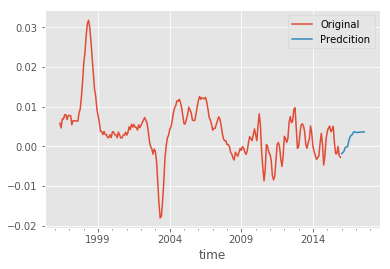

In [184]:
forecast = results.get_forecast(steps=20)
m_forecast = forecast.predicted_mean
train.plot(label='Original',legend=True)
m_forecast.plot(label='Predcition',legend=True)

SARIMA model RMSE on train data:0.001956403675534825
SARIMA model RMSE on test data:0.008441127667917185


NameError: name 'best' is not defined

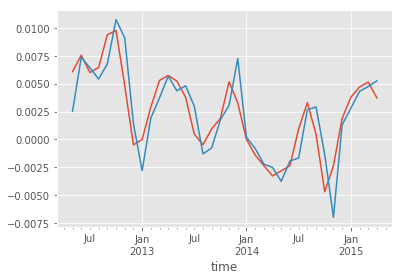

In [291]:
make_pred(train, test, results)

In [178]:
m_fore

2016-01-01   -0.001810
2016-02-01   -0.001556
2016-03-01   -0.001210
2016-04-01   -0.000272
2016-05-01   -0.000102
2016-06-01   -0.000058
2016-07-01    0.001369
2016-08-01    0.002334
2016-09-01    0.002824
2016-10-01    0.002988
2016-11-01    0.003671
2016-12-01    0.003717
2017-01-01    0.003509
2017-02-01    0.003540
2017-03-01    0.003569
2017-04-01    0.003595
2017-05-01    0.003619
2017-06-01    0.003642
2017-07-01    0.003662
2017-08-01    0.003681
2017-09-01    0.003699
2017-10-01    0.003715
2017-11-01    0.003730
2017-12-01    0.003744
2018-01-01    0.003756
2018-02-01    0.003768
2018-03-01    0.003779
2018-04-01    0.003789
2018-05-01    0.003798
2018-06-01    0.003807
2018-07-01    0.003815
2018-08-01    0.003822
2018-09-01    0.003829
2018-10-01    0.003835
2018-11-01    0.003840
2018-12-01    0.003846
Freq: MS, dtype: float64

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
# Plot seasonal ACF
plot_acf(ts_zc20.diff(periods=12).dropna(), ax=ax1)
# Plot seasonal PACF
plot_pacf(ts_zc20.diff(periods=12).dropna(), ax=ax2)
plt.show()


In [ ]:
autocorrelation_plot(ts_zc20.diff().dropna())

In [ ]:
aloo = zc20_melt.groupby('time').mean()
aloo[aloo['value']==aloo['2009':'2014'].min()[1]].index

In [ ]:
mock_df=df.copy()
mock_df['std']=mock_df.iloc[:,7:].std(axis=1)
mock_df['avg']=mock_df.iloc[:,7:-1].mean(axis=1)
mock_df['ROI']=(mock_df.iloc[:,-3] - mock_df.iloc[:,7])/mock_df.iloc[:,7] 
mock_df['cv']=(mock_df['std']/mock_df['avg'])*100

In [ ]:
mock_df[['RegionName','City','State','ROI','cv','std']].sort_values('ROI',ascending=False)[:10]

In [ ]:
mock_df.iloc[:,-5]

In [ ]:
florida = df[df['State']=='FL'].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
florida.head()

In [ ]:
melt_mock = df.copy()

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','RegionID','City','State','Metro','CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [ ]:
melt_mock = melt_data(df)
zc60657 = melt_mock[melt_mock['RegionName']==60657].copy()

In [ ]:
zc60657.set_index('time',inplace=True)
zc60657.index

In [ ]:
zc60657

In [ ]:
for i in range(len(zc60657)-1):
    zc60657['yr_return'][i+1]=((zc60657['value'][i+1]-zc60657['value'][i])/zc60657['value'][i])*100
zc60657.tail()

In [ ]:
zc60657['yr_return']=0*len(zc60657)

In [ ]:
zc60657['yr_return']